<h1>Machine Learning on Big Data Project</h1>
<h3>Fatoumata Wadiou & Pénélope Millet</h3>

# MapReduce Workflow for k-NN

## RDD vs. DF

### PARAMETRES PAR DEFAULT (#cores = 2, #partition = 200)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array, row_number, count, udf, spark_partition_id
from pyspark.sql.window import Window
import math
import time

# -------------------------------
# INITIALISATION SPARK
# -------------------------------
spark = SparkSession.builder.appName("kNN_Maillo").getOrCreate()
sc = spark.sparkContext

# -------------------------------
# LOAD TRAIN AND TEST DATASET
# -------------------------------
cols = [f"f{i}" for i in range(10)] + ["label"]
n_train = 10000
n_test = int(0.2 * n_train)

train = spark.read.csv("poker-hand-training-true.data", header=False, inferSchema=True).toDF(*cols).limit(n_train)
test = spark.read.csv("poker-hand-testing.data", header=False, inferSchema=True).toDF(*cols).limit(n_test)

print(f"train size: {train.count()}")
print(f"test size: {test.count()}")

# -------------------------------
# PARAMÈTRES
# -------------------------------
k = 5

# =========================================================
# VERSION RDD
# =========================================================
test_points = test.collect()
test_broadcast = sc.broadcast(test_points)

def euclidean_distance(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def map_knn_local(partition):
    """
    Phase Map : chaque partition calcule distances test/train
    et garde les k voisins LOCAUX pour chaque test point.
    """
    partition = list(partition)
    results = {i: [] for i in range(len(test_broadcast.value))}

    for idx, test_point in enumerate(test_broadcast.value):
        test_features = [test_point[f"f{i}"] for i in range(10)]
        local_neighbors = []

        for train_point in partition:
            train_features = [train_point[f"f{i}"] for i in range(10)]
            dist = euclidean_distance(test_features, train_features)
            local_neighbors.append((dist, train_point["label"]))

        # garder les k voisins locaux
        local_neighbors = sorted(local_neighbors, key=lambda x: x[0])[:k]
        results[idx] = local_neighbors

    for idx, neighbors in results.items():
        yield (idx, neighbors)

def reduce_knn_global(neighbors_lists):
    """
    Phase Reduce : fusionne toutes les listes locales
    et garde les k meilleurs globalement.
    """
    merged = []
    for lst in neighbors_lists:
        merged.extend(lst)
    return sorted(merged, key=lambda x: x[0])[:k]

def majority_vote(neighbors):
    labels = [lbl for _, lbl in neighbors]
    return max(set(labels), key=labels.count)

# --- Pipeline RDD
start_rdd = time.time()

mapped = train.rdd.mapPartitions(map_knn_local)
reduced = mapped.groupByKey().mapValues(reduce_knn_global)
predictions_rdd = reduced.mapValues(majority_vote)

# Évaluation précision
correct_rdd = predictions_rdd.filter(lambda x: test_broadcast.value[x[0]]["label"] == x[1]).count()
total_rdd = predictions_rdd.count()
accuracy_rdd = correct_rdd / total_rdd

time_rdd = time.time() - start_rdd
print(f"\nRDD (Maillo-style) => Accuracy: {accuracy_rdd:.4f}, Time: {time_rdd:.2f}s")

# =========================================================
# VERSION DATAFRAME
# =========================================================
# Ajout features
train = train.withColumn("features", array(*[col(f"f{i}") for i in range(10)]))
test = test.withColumn("features", array(*[col(f"f{i}") for i in range(10)]))

# Distance UDF
def euclidean_distance_udf(f1, f2):
    return float(math.sqrt(sum((a - b) ** 2 for a, b in zip(f1,f2))))
distance_udf = udf(euclidean_distance_udf, "float")

start_df = time.time()

# Cross join train/test
df_cross = test.crossJoin(train.withColumnRenamed("features","train_features")
                                  .withColumnRenamed("label","train_label"))

# Calcul distance
df_cross = df_cross.withColumn("distance", distance_udf(col("features"), col("train_features")))

# --- MAP phase (gardons k voisins locaux par partition)
window_local = Window.partitionBy("features", spark_partition_id()).orderBy(col("distance").asc())
df_local_knn = df_cross.withColumn("rn", row_number().over(window_local)).filter(col("rn") <= k)

# --- REDUCE phase (fusion et garde k globaux)
window_global = Window.partitionBy("features").orderBy(col("distance").asc())
df_global_knn = df_local_knn.withColumn("rn_global", row_number().over(window_global)).filter(col("rn_global") <= k)

# --- Vote majoritaire
window_vote = Window.partitionBy("features", "train_label")
df_votes = df_global_knn.withColumn("cnt", count("train_label").over(window_vote))

window_max = Window.partitionBy("features").orderBy(col("cnt").desc())
df_pred = df_votes.withColumn("rn_vote", row_number().over(window_max)).filter(col("rn_vote") == 1)

# --- Évaluation
df_eval = df_pred.withColumn("correct", (col("label") == col("train_label")).cast("integer"))
accuracy_df = df_eval.agg({"correct":"avg"}).collect()[0][0]

time_df = time.time() - start_df
print(f"DataFrame (Maillo-style) => Accuracy: {accuracy_df:.4f}, Time: {time_df:.2f}s")

# -------------------------------
spark.stop()


train size: 10000
test size: 2000

RDD (Maillo-style) => Accuracy: 0.5440, Time: 211.10s
DataFrame (Maillo-style) => Accuracy: 0.5420, Time: 267.38s


### PARAMETRES OPTIMISÉS (#partitions = 4, 6, 8)

Pour un bon parallélisme : Nombre de partitions ≈ 2 à 4 fois le nombre de cores

2 cores disponibles => nombre partitions entre 4 et 8

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array, row_number, count, udf, spark_partition_id
from pyspark.sql.window import Window
import math
import time
import pandas as pd

# -------------------------------
# INITIALISATION SPARK
# -------------------------------
spark = SparkSession.builder.appName("kNN_Maillo_k_variation").getOrCreate()
sc = spark.sparkContext

# -------------------------------
# LOAD TRAIN AND TEST DATASET
# -------------------------------
cols = [f"f{i}" for i in range(10)] + ["label"]
n_train = 10000
n_test = int(0.2 * n_train)

train = spark.read.csv("poker-hand-training-true.data", header=False, inferSchema=True).toDF(*cols).limit(n_train)
test = spark.read.csv("poker-hand-testing.data", header=False, inferSchema=True).toDF(*cols).limit(n_test)

print(f"train size: {train.count()}, test size: {test.count()}")

# -------------------------------
# Distance RDD/DataFrame
# -------------------------------
def euclidean_distance(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def map_knn_local(partition):
    partition = list(partition)
    results = {i: [] for i in range(len(test_broadcast.value))}
    for idx, test_point in enumerate(test_broadcast.value):
        test_features = [test_point[f"f{i}"] for i in range(10)]
        local_neighbors = []
        for train_point in partition:
            train_features = [train_point[f"f{i}"] for i in range(10)]
            dist = euclidean_distance(test_features, train_features)
            local_neighbors.append((dist, train_point["label"]))
        local_neighbors = sorted(local_neighbors, key=lambda x: x[0])[:current_k]
        results[idx] = local_neighbors
    for idx, neighbors in results.items():
        yield (idx, neighbors)

def reduce_knn_global(neighbors_lists):
    merged = []
    for lst in neighbors_lists:
        merged.extend(lst)
    return sorted(merged, key=lambda x: x[0])[:current_k]

def majority_vote(neighbors):
    labels = [lbl for _, lbl in neighbors]
    return max(set(labels), key=labels.count)

distance_udf = udf(lambda f1, f2: float(math.sqrt(sum((a-b)**2 for a,b in zip(f1,f2)))), "float")

# -------------------------------
# Paramètres à tester
# -------------------------------
k_values = [3, 5, 7]      # Valeurs de k
partitions_list = [4, 6, 8]  # Nombre de partitions
results = []

# -------------------------------
# Broadcast des test points pour RDD
# -------------------------------
test_points = test.collect()
test_broadcast = sc.broadcast(test_points)

# -------------------------------
# Boucle sur toutes les combinaisons
# -------------------------------
for current_k in k_values:
    # ---------------- RDD ----------------
    for n_partitions in partitions_list:
        train_rdd = train.rdd.repartition(n_partitions)
        start_rdd = time.time()
        mapped = train_rdd.mapPartitions(map_knn_local)
        reduced = mapped.groupByKey().mapValues(reduce_knn_global)
        predictions_rdd = reduced.mapValues(majority_vote)
        correct_rdd = predictions_rdd.filter(lambda x: test_broadcast.value[x[0]]["label"] == x[1]).count()
        total_rdd = predictions_rdd.count()
        accuracy_rdd = correct_rdd / total_rdd
        time_rdd = time.time() - start_rdd

        results.append({
            "version": "RDD",
            "k": current_k,
            "partitions": n_partitions,
            "accuracy": accuracy_rdd,
            "time": time_rdd
        })
        print(f"RDD - k={current_k}, Partitions={n_partitions} => Accuracy={accuracy_rdd:.4f}, Time={time_rdd:.2f}s")

    # ---------------- DataFrame ----------------
    train_df = train.withColumn("features", array(*[col(f"f{i}") for i in range(10)]))
    test_df = test.withColumn("features", array(*[col(f"f{i}") for i in range(10)]))

    for n_partitions in partitions_list:
        spark.conf.set("spark.sql.shuffle.partitions", n_partitions)

        start_df = time.time()
        df_cross = test_df.crossJoin(train_df.withColumnRenamed("features","train_features")
                                      .withColumnRenamed("label","train_label"))
        df_cross = df_cross.withColumn("distance", distance_udf(col("features"), col("train_features")))

        # MAP phase
        window_local = Window.partitionBy("features", spark_partition_id()).orderBy(col("distance").asc())
        df_local_knn = df_cross.withColumn("rn", row_number().over(window_local)).filter(col("rn") <= current_k)

        # REDUCE phase
        window_global = Window.partitionBy("features").orderBy(col("distance").asc())
        df_global_knn = df_local_knn.withColumn("rn_global", row_number().over(window_global)).filter(col("rn_global") <= current_k)

        # Vote majoritaire
        window_vote = Window.partitionBy("features", "train_label")
        df_votes = df_global_knn.withColumn("cnt", count("train_label").over(window_vote))
        window_max = Window.partitionBy("features").orderBy(col("cnt").desc())
        df_pred = df_votes.withColumn("rn_vote", row_number().over(window_max)).filter(col("rn_vote") == 1)

        df_eval = df_pred.withColumn("correct", (col("label") == col("train_label")).cast("integer"))
        accuracy_df = df_eval.agg({"correct":"avg"}).collect()[0][0]
        time_df = time.time() - start_df

        results.append({
            "version": "DataFrame",
            "k": current_k,
            "partitions": n_partitions,
            "accuracy": accuracy_df,
            "time": time_df
        })
        print(f"DataFrame - k={current_k}, Partitions={n_partitions} => Accuracy={accuracy_df:.4f}, Time={time_df:.2f}s")

# -------------------------------
# Affichage tableau des résultats
# -------------------------------
df_results = pd.DataFrame(results)
print("\nTableau des résultats :")
print(df_results)

# -------------------------------
spark.stop()


train size: 10000, test size: 2000
RDD - k=3, Partitions=4 => Accuracy=0.5350, Time=223.39s
RDD - k=3, Partitions=6 => Accuracy=0.5390, Time=217.03s
RDD - k=3, Partitions=8 => Accuracy=0.5385, Time=218.24s
DataFrame - k=3, Partitions=4 => Accuracy=0.5380, Time=239.51s
DataFrame - k=3, Partitions=6 => Accuracy=0.5380, Time=232.29s
DataFrame - k=3, Partitions=8 => Accuracy=0.5380, Time=229.35s
RDD - k=5, Partitions=4 => Accuracy=0.5435, Time=216.74s
RDD - k=5, Partitions=6 => Accuracy=0.5380, Time=216.72s
RDD - k=5, Partitions=8 => Accuracy=0.5410, Time=218.02s
DataFrame - k=5, Partitions=4 => Accuracy=0.5420, Time=266.28s
DataFrame - k=5, Partitions=6 => Accuracy=0.5420, Time=249.61s
DataFrame - k=5, Partitions=8 => Accuracy=0.5420, Time=261.07s
RDD - k=7, Partitions=4 => Accuracy=0.5540, Time=220.74s
RDD - k=7, Partitions=6 => Accuracy=0.5545, Time=217.27s
RDD - k=7, Partitions=8 => Accuracy=0.5475, Time=225.21s
DataFrame - k=7, Partitions=4 => Accuracy=0.5520, Time=249.96s
DataFrame -

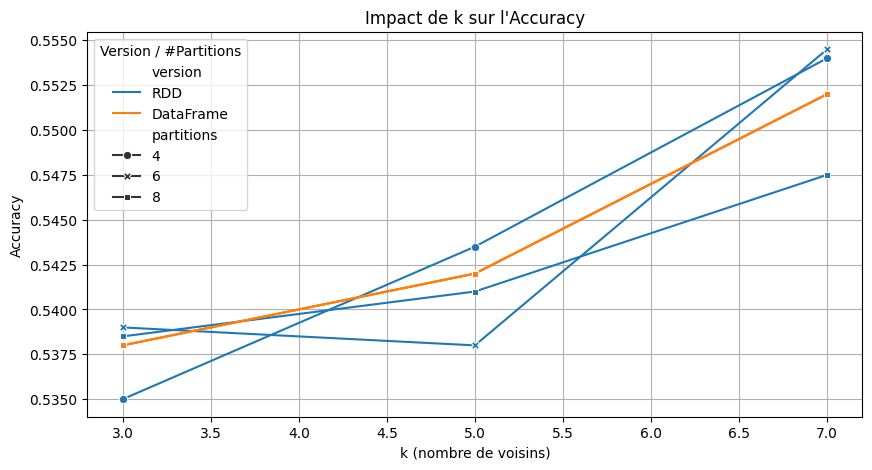

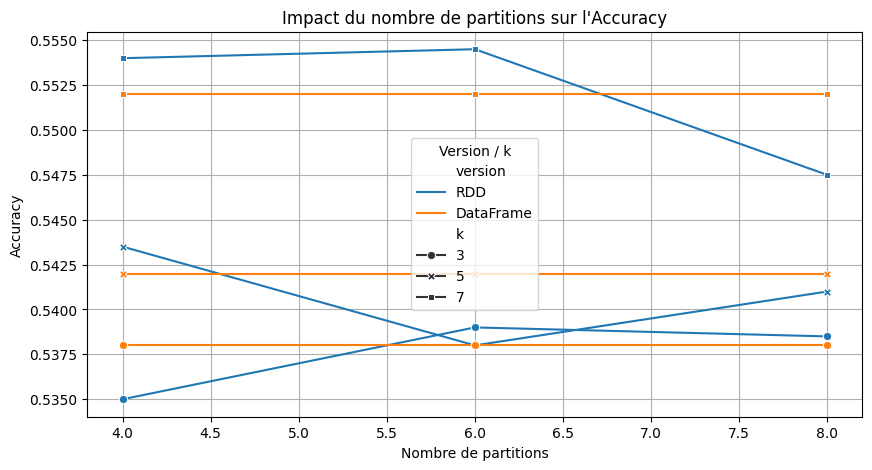

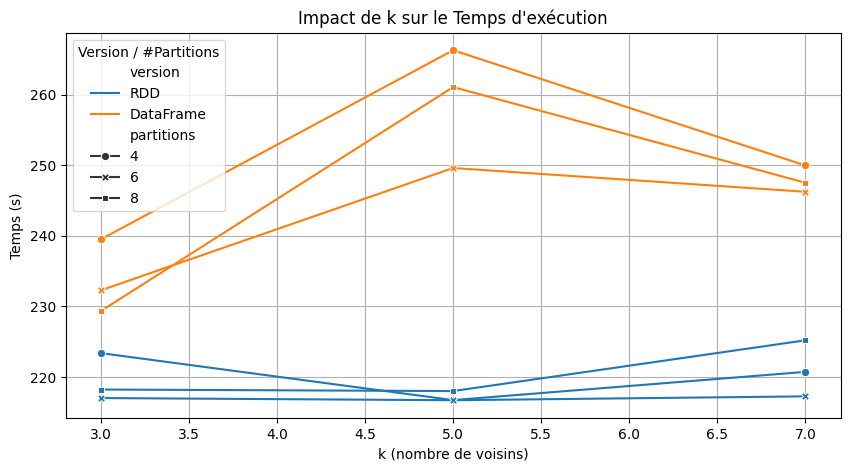

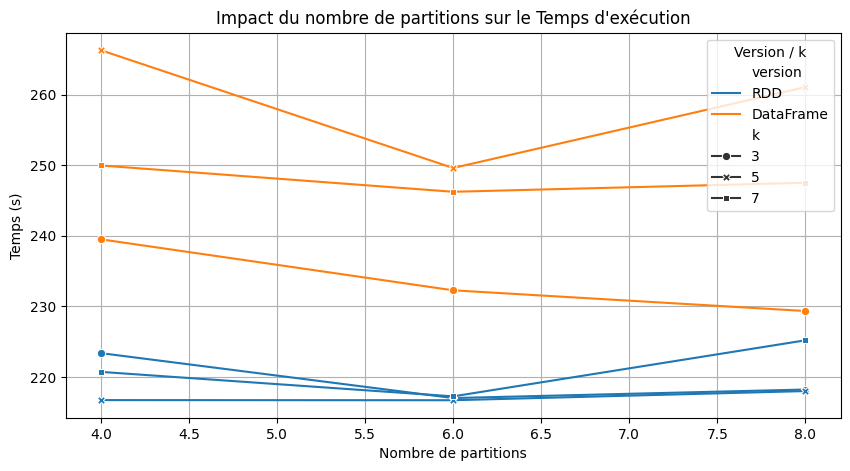

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# df_results est le DataFrame Pandas contenant tes résultats
# Colonnes : version, k, partitions, accuracy, time

# -------------------------------
# Graphique Accuracy en fonction de k
# -------------------------------
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x="k", y="accuracy", hue="version", style="partitions", markers=True, dashes=False)
plt.title("Impact de k sur l'Accuracy")
plt.xlabel("k (nombre de voisins)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Version / #Partitions")
plt.show()

# -------------------------------
# Graphique Accuracy en fonction du nombre de partitions
# -------------------------------
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x="partitions", y="accuracy", hue="version", style="k", markers=True, dashes=False)
plt.title("Impact du nombre de partitions sur l'Accuracy")
plt.xlabel("Nombre de partitions")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Version / k")
plt.show()

# -------------------------------
# Graphique Temps en fonction de k
# -------------------------------
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x="k", y="time", hue="version", style="partitions", markers=True, dashes=False)
plt.title("Impact de k sur le Temps d'exécution")
plt.xlabel("k (nombre de voisins)")
plt.ylabel("Temps (s)")
plt.grid(True)
plt.legend(title="Version / #Partitions")
plt.show()

# -------------------------------
# Graphique Temps en fonction du nombre de partitions
# -------------------------------
plt.figure(figsize=(10,5))
sns.lineplot(data=df_results, x="partitions", y="time", hue="version", style="k", markers=True, dashes=False)
plt.title("Impact du nombre de partitions sur le Temps d'exécution")
plt.xlabel("Nombre de partitions")
plt.ylabel("Temps (s)")
plt.grid(True)
plt.legend(title="Version / k")
plt.show()


### SCALABILITÉ

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, array, row_number, count, udf, spark_partition_id
from pyspark.sql.window import Window
import math, time
import pandas as pd

# -------------------------------
# INITIALISATION SPARK
# -------------------------------
spark = SparkSession.builder.appName("kNN_Scalability").getOrCreate()
sc = spark.sparkContext

# -------------------------------
# PARAMÈTRES
# -------------------------------
cols = [f"f{i}" for i in range(10)] + ["label"]
k = 5
num_partitions = 6
sample_sizes = [500, 2000, 5000, 10000, 15000]  # tailles d'échantillons à tester

results = []

# -------------------------------
# BOUCLE SUR LES TAILLES
# -------------------------------
for n_train in sample_sizes:
    n_test = int(0.2 * n_train)

    print(f"\n=== Test avec n_train={n_train}, n_test={n_test} ===")

    # Charger données
    train = spark.read.csv("poker-hand-training-true.data", header=False, inferSchema=True) \
                     .toDF(*cols).limit(n_train).repartition(num_partitions)
    test = spark.read.csv("poker-hand-testing.data", header=False, inferSchema=True) \
                    .toDF(*cols).limit(n_test).repartition(num_partitions)

    # -------------------------------
    # VERSION RDD
    # -------------------------------
    test_points = test.collect()
    test_broadcast = sc.broadcast(test_points)

    start_rdd = time.time()
    mapped = train.rdd.mapPartitions(map_knn_local)
    reduced = mapped.groupByKey().mapValues(reduce_knn_global)
    predictions_rdd = reduced.mapValues(majority_vote)

    correct_rdd = predictions_rdd.filter(lambda x: test_broadcast.value[x[0]]["label"] == x[1]).count()
    total_rdd = predictions_rdd.count()
    accuracy_rdd = correct_rdd / total_rdd
    time_rdd = time.time() - start_rdd

    results.append(("RDD", n_train, accuracy_rdd, time_rdd))

    # -------------------------------
    # VERSION DATAFRAME
    # -------------------------------
    train = train.withColumn("features", array(*[col(f"f{i}") for i in range(10)]))
    test = test.withColumn("features", array(*[col(f"f{i}") for i in range(10)]))

    start_df = time.time()
    df_cross = test.crossJoin(train.withColumnRenamed("features","train_features")
                                      .withColumnRenamed("label","train_label"))
    df_cross = df_cross.withColumn("distance", distance_udf(col("features"), col("train_features")))

    window_local = Window.partitionBy("features", spark_partition_id()).orderBy(col("distance").asc())
    df_local_knn = df_cross.withColumn("rn", row_number().over(window_local)).filter(col("rn") <= k)

    window_global = Window.partitionBy("features").orderBy(col("distance").asc())
    df_global_knn = df_local_knn.withColumn("rn_global", row_number().over(window_global)).filter(col("rn_global") <= k)

    window_vote = Window.partitionBy("features", "train_label")
    df_votes = df_global_knn.withColumn("cnt", count("train_label").over(window_vote))

    window_max = Window.partitionBy("features").orderBy(col("cnt").desc())
    df_pred = df_votes.withColumn("rn_vote", row_number().over(window_max)).filter(col("rn_vote") == 1)

    df_eval = df_pred.withColumn("correct", (col("label") == col("train_label")).cast("integer"))
    accuracy_df = df_eval.agg({"correct":"avg"}).collect()[0][0]
    time_df = time.time() - start_df

    results.append(("DataFrame", n_train, accuracy_df, time_df))

# -------------------------------
# RÉSULTATS FINAUX
# -------------------------------
df_results = pd.DataFrame(results, columns=["Version", "TrainSize", "Accuracy", "Time"])
print("\n=== Résultats comparatifs ===")
print(df_results)

# -------------------------------
spark.stop()



=== Test avec n_train=500, n_test=100 ===

=== Test avec n_train=2000, n_test=400 ===

=== Test avec n_train=5000, n_test=1000 ===

=== Test avec n_train=10000, n_test=2000 ===

=== Test avec n_train=15000, n_test=3000 ===

=== Résultats comparatifs ===
     Version  TrainSize  Accuracy        Time
0        RDD        500  0.450000    4.822616
1  DataFrame        500  0.410000    4.438278
2        RDD       2000  0.520000   11.302446
3  DataFrame       2000  0.512500   10.681502
4        RDD       5000  0.533000   56.315580
5  DataFrame       5000  0.544000   50.565932
6        RDD      10000  0.552500  219.174429
7  DataFrame      10000  0.539500  216.191402
8        RDD      15000  0.550333  488.369682
9  DataFrame      15000  0.545000  507.707148


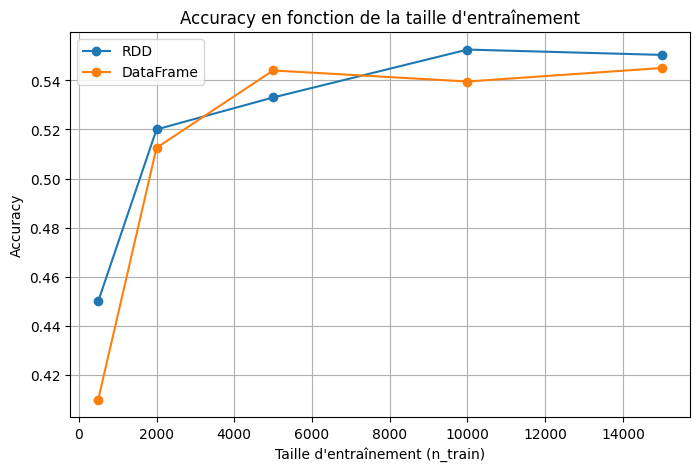

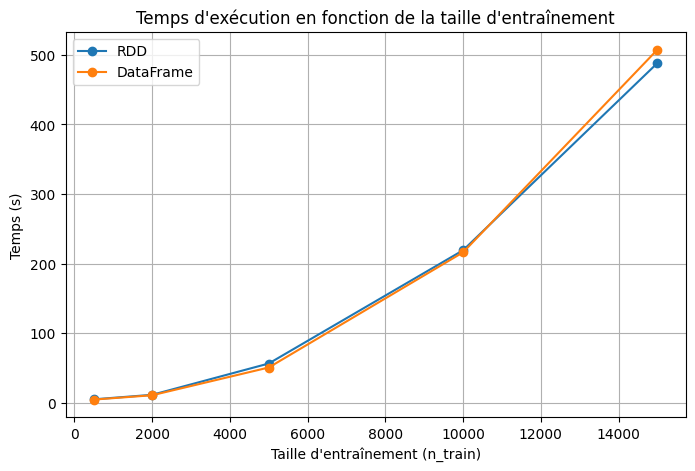

In [7]:
import matplotlib.pyplot as plt

# -------------------------------
# VISUALISATION
# -------------------------------

# Courbe Accuracy
plt.figure(figsize=(8,5))
for version in df_results["Version"].unique():
    subset = df_results[df_results["Version"] == version]
    plt.plot(subset["TrainSize"], subset["Accuracy"], marker="o", label=version)

plt.title("Accuracy en fonction de la taille d'entraînement")
plt.xlabel("Taille d'entraînement (n_train)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Courbe Temps
plt.figure(figsize=(8,5))
for version in df_results["Version"].unique():
    subset = df_results[df_results["Version"] == version]
    plt.plot(subset["TrainSize"], subset["Time"], marker="o", label=version)

plt.title("Temps d'exécution en fonction de la taille d'entraînement")
plt.xlabel("Taille d'entraînement (n_train)")
plt.ylabel("Temps (s)")
plt.legend()
plt.grid(True)
plt.show()


# Spark ML

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, BucketedRandomProjectionLSH
import time
import pandas as pd

# -------------------------------
# Spark session
# -------------------------------
spark = SparkSession.builder.appName("kNN_MapReduce_SparkML").getOrCreate()

# -------------------------------
# Load dataset
# -------------------------------
cols = [f"f{i}" for i in range(10)] + ["label"]
n_train = 10000
n_test = int(0.2 * n_train)

train = spark.read.csv("poker-hand-training-true.data", header=False, inferSchema=True) \
            .toDF(*cols).limit(n_train)
test = spark.read.csv("poker-hand-testing.data", header=False, inferSchema=True) \
           .toDF(*cols).limit(n_test)

print(f"Train size: {train.count()}, Test size: {test.count()}")

# -------------------------------
# Préparer les features
# -------------------------------
assembler = VectorAssembler(inputCols=[f"f{i}" for i in range(10)], outputCol="features")
train_ml = assembler.transform(train).select("features", "label")
test_ml = assembler.transform(test).select("features", "label")

# -------------------------------
# Paramètres à tester
# -------------------------------
k_values = [3, 5, 7]
bucket_lengths = [1.0, 2.0, 3.0]

results = []

# -------------------------------
# Boucle sur toutes les combinaisons
# -------------------------------
for k in k_values:
    for bucket_len in bucket_lengths:
        start_time = time.time()

        # Phase Map : voisins partiels avec LSH
        brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",
                                          bucketLength=bucket_len, numHashTables=3)
        model = brp.fit(train_ml)

        neighbors_partial = model.approxSimilarityJoin(
            test_ml, train_ml, float("inf"), distCol="dist"
        ).select(
            F.col("datasetA.features").alias("test_features"),
            F.col("datasetA.label").alias("true_label"),
            F.col("datasetB.label").alias("neighbor_label"),
            F.col("dist")
        )

        # Garder les k voisins les plus proches (Map)
        window_local = Window.partitionBy("test_features").orderBy(F.col("dist").asc())
        neighbors_topk = neighbors_partial.withColumn("rank", F.row_number().over(window_local)) \
                                          .filter(F.col("rank") <= k)

        # Phase Reduce : vote majoritaire
        votes = neighbors_topk.groupBy("test_features", "true_label", "neighbor_label").count()
        window_vote = Window.partitionBy("test_features").orderBy(F.col("count").desc())
        predictions = votes.withColumn("rn", F.row_number().over(window_vote)) \
                           .filter(F.col("rn") == 1) \
                           .withColumnRenamed("neighbor_label", "pred")

        # Évaluation
        accuracy = predictions.filter(F.col("true_label") == F.col("pred")).count() / test_ml.count()
        time_elapsed = time.time() - start_time

        # Stocker les résultats
        results.append({
            "k": k,
            "bucketLength": bucket_len,
            "accuracy": accuracy,
            "time": time_elapsed
        })

        print(f"k={k}, bucketLength={bucket_len} => Accuracy={accuracy:.4f}, Time={time_elapsed:.2f}s")

# -------------------------------
# Affichage tableau des résultats
# -------------------------------
df_results = pd.DataFrame(results)
print("\nTableau des résultats :")
print(df_results)

# -------------------------------
spark.stop()


Train size: 10000, Test size: 2000
k=3, bucketLength=1.0 => Accuracy=0.5270, Time=171.06s
k=3, bucketLength=2.0 => Accuracy=0.5295, Time=280.73s
k=3, bucketLength=3.0 => Accuracy=0.5285, Time=384.33s
k=5, bucketLength=1.0 => Accuracy=0.5220, Time=130.93s
k=5, bucketLength=2.0 => Accuracy=0.5370, Time=248.12s
k=5, bucketLength=3.0 => Accuracy=0.5365, Time=277.50s
k=7, bucketLength=1.0 => Accuracy=0.5295, Time=118.66s
k=7, bucketLength=2.0 => Accuracy=0.5450, Time=224.39s
k=7, bucketLength=3.0 => Accuracy=0.5510, Time=299.30s

Tableau des résultats :
   k  bucketLength  accuracy        time
0  3           1.0    0.5270  171.064173
1  3           2.0    0.5295  280.726552
2  3           3.0    0.5285  384.329712
3  5           1.0    0.5220  130.928017
4  5           2.0    0.5370  248.122312
5  5           3.0    0.5365  277.501126
6  7           1.0    0.5295  118.659844
7  7           2.0    0.5450  224.392770
8  7           3.0    0.5510  299.303536


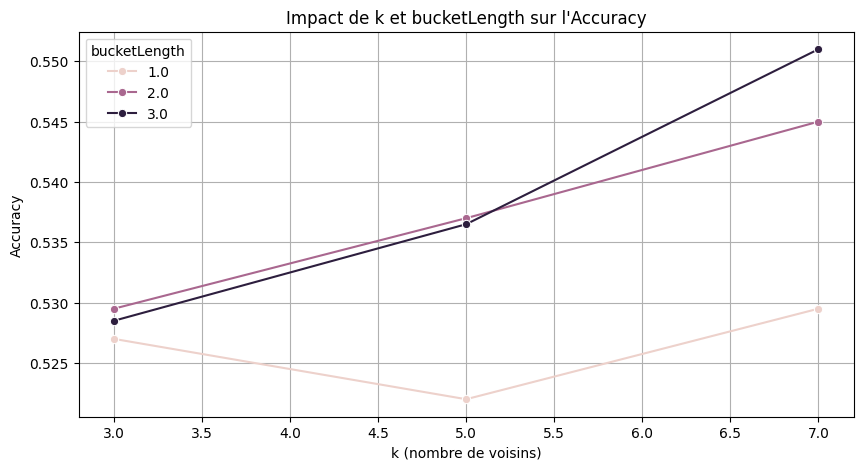

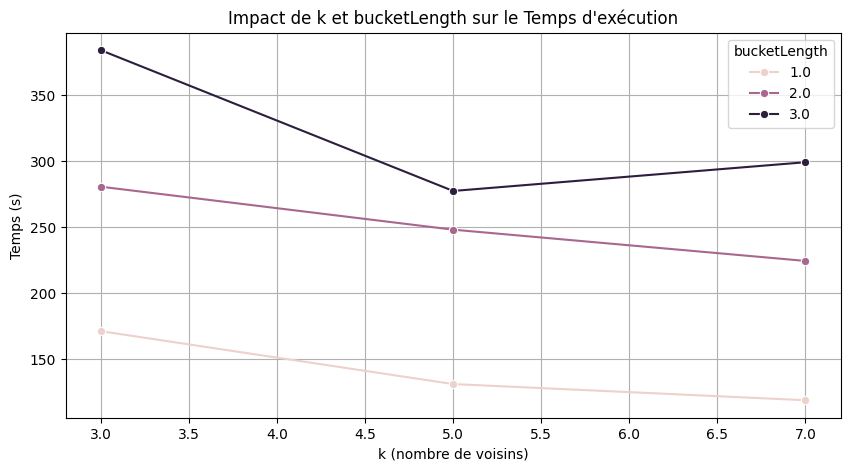

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------------
# Transformer les résultats en DataFrame
# -------------------------------
df_results = pd.DataFrame(results)

# -------------------------------
# Graphique Accuracy
# -------------------------------
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_results, x="k", y="accuracy", hue="bucketLength", marker="o")
plt.title("Impact de k et bucketLength sur l'Accuracy")
plt.xlabel("k (nombre de voisins)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="bucketLength")
plt.show()

# -------------------------------
# Graphique Temps d'exécution
# -------------------------------
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_results, x="k", y="time", hue="bucketLength", marker="o")
plt.title("Impact de k et bucketLength sur le Temps d'exécution")
plt.xlabel("k (nombre de voisins)")
plt.ylabel("Temps (s)")
plt.grid(True)
plt.legend(title="bucketLength")
plt.show()
